# GAN: генерация лиц на датасете Anime faces

In [2]:
import numpy as np
from texttable import Texttable
import matplotlib.pyplot as plt
from warnings import filterwarnings

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision as tv
from torchvision import datasets

In [3]:
N_EPOCHS = 200          #number of epochs of training
BATCH_SIZE = 25         #size of the batches
LR = 2e-4               #adam: learning rate
B1 = .5                 #adam: decay of first order momentum of gradient
B2 = .999               #adam: decay of first order momentum of gradient
LATENT_DIM = 100        #dimensionality of the latent space
IMG_SIZE = 128          #size of each image dimension
CHANNELS = 3            #number of image channels
SAMPLE_INTERVAL = 400   #interval between image sampling

In [4]:
filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
transformer = tv.transforms.Compose([tv.transforms.Resize(IMG_SIZE), 
                                     tv.transforms.ToTensor(), 
                                     tv.transforms.Normalize([0.5], [0.5])]
                                     )
path = "./anime_faces"
train_data = tv.datasets.ImageFolder(path, transformer)
dataloader = torch.utils.data.DataLoader(train_data, BATCH_SIZE, shuffle=True)

In [6]:
def peep(data, H, W, random=True):
    fig = plt.figure(figsize=(16,3*H))
    for i in range(H * W):
        fig.add_subplot(H, W, i + 1)
        if random:
            img_number = int(np.random.choice(len(data), 1))
        else:
            assert data.shape[0] >= H * W
            img_number = H * W - i
        plt.imshow(data[img_number][0].permute(1,2,0).clip(0), cmap='Greys')
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
    plt.show()

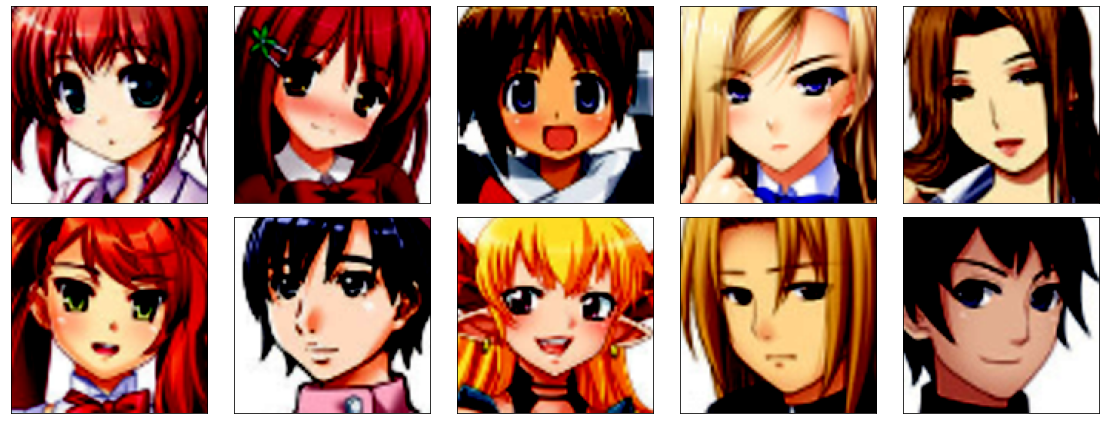

In [7]:
peep(train_data, 2, 5)

In [8]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = IMG_SIZE // 4
        self.l1 = nn.Sequential(nn.Linear(LATENT_DIM, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(nn.BatchNorm2d(128),
                                         nn.Upsample(scale_factor=2),
                                         nn.Conv2d(128, 128, 3, stride=1, padding=1),
                                         nn.BatchNorm2d(128, 0.8),
                                         nn.LeakyReLU(0.2, inplace=True),
                                         nn.Upsample(scale_factor=2),
                                         nn.Conv2d(128, 64, 3, stride=1, padding=1),
                                         nn.BatchNorm2d(64, 0.8),
                                         nn.LeakyReLU(0.2, inplace=True),
                                         nn.Conv2d(64, CHANNELS, 3, stride=1, padding=1),
                                         nn.Tanh(),
                                         )


    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), 
                     nn.LeakyReLU(0.2, inplace=True), 
                     nn.Dropout2d(0.25)
                     ]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(*discriminator_block(CHANNELS, 16, bn=False),
                                   *discriminator_block(16, 32),
                                   *discriminator_block(32, 64),
                                   *discriminator_block(64, 128),
                                   )

        # The height and width of downsampled image
        ds_size = IMG_SIZE // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())


    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [11]:
# Loss function
adversarial_loss = torch.nn.BCELoss().to(device)

# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)


# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=LR, betas=(B1, B2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=(B1, B2))


In [12]:
# ----------
#  Training
# ----------

table = Texttable()
table.set_deco(Texttable.HEADER | Texttable.VLINES)\
     .set_chars(['', '|', '+', '-'])\
     .set_cols_width([10,10,20,20])\
     .set_cols_align(["c", "c", "c", "c"])\
     .header(["Epochs", "Batch", "Generator loss", "Discriminator loss"])
print(table.draw())

for epoch in range(N_EPOCHS):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        with torch.no_grad():
            valid = torch.cuda.FloatTensor(imgs.shape[0], 1).fill_(1.0)
            fake = torch.cuda.FloatTensor(imgs.shape[0], 1).fill_(0.0)

        # Configure input
        real_imgs = imgs.type(torch.cuda.FloatTensor)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = torch.cuda.FloatTensor(np.random.normal(0, 1, (imgs.shape[0], LATENT_DIM)))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        if i % (len(dataloader) // 3) == 0:
            output = ['{}/{}'.format(epoch, N_EPOCHS), '{}/{}'.format(i, len(dataloader)), g_loss.item(), d_loss.item()]
            table.reset().add_row(output)
            print(table.draw())

  Epochs   |   Batch    |    Generator loss    |  Discriminator loss 
-----------+------------+----------------------+---------------------
  0/200    |   0/863    |        0.699         |        0.693        
  0/200    |  287/863   |        0.709         |        0.677        
  0/200    |  574/863   |        0.675         |        0.706        
  0/200    |  861/863   |        0.678         |        0.666        
  1/200    |   0/863    |        0.659         |        0.697        
  1/200    |  287/863   |        0.704         |        0.688        
  1/200    |  574/863   |        0.723         |        0.702        
  1/200    |  861/863   |        0.691         |        0.676        
  2/200    |   0/863    |        0.693         |        0.661        
  2/200    |  287/863   |        0.644         |        0.707        
  2/200    |  574/863   |        0.738         |        0.693        
  2/200    |  861/863   |        0.701         |        0.691        
  3/200    |   0/863

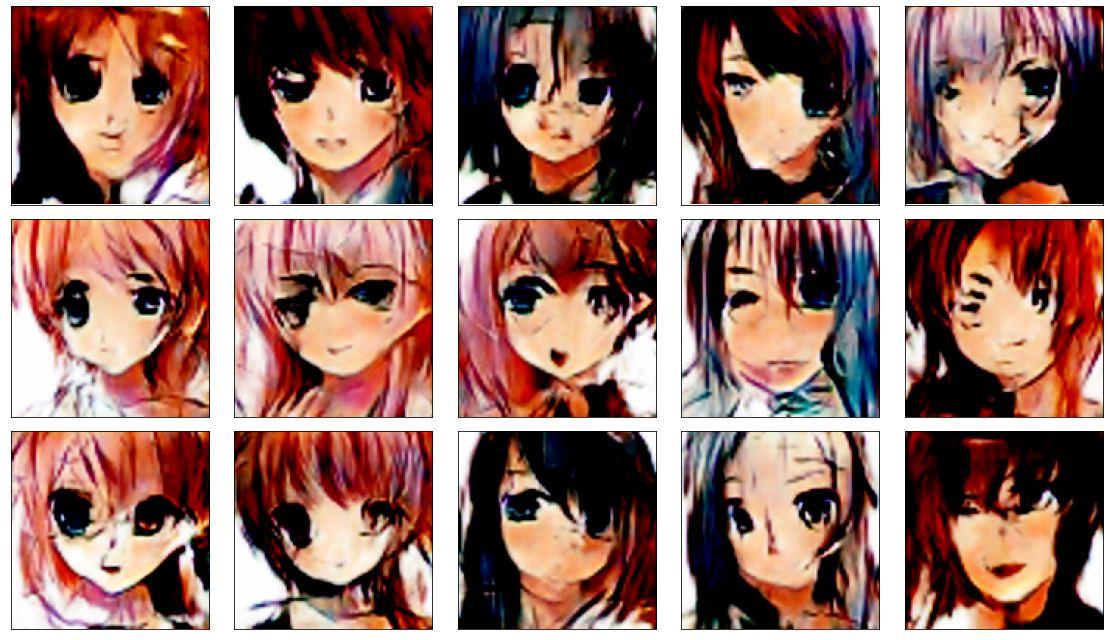

In [31]:
with torch.no_grad():
    generated_imgs = generator(torch.cuda.FloatTensor(np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))))
peep(generated_imgs.unsqueeze(1).cpu(), 3, 5, random=False)